In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PyOMA as oma
import obspy
import mplcursors

from scipy import signal
from obspy.clients.filesystem.sds import Client

In [2]:
def __get_data_all(config):

    from tqdm.notebook import tqdm

    net, sta, loc, cha = config['seed'].split(".")

    st0 = obspy.Stream()

    for sta in tqdm(config['stations']):

        try:
            st = config['client'].get_waveforms(network=net, station=sta, location=loc, channel=cha,
                                                starttime=config['tbeg'], endtime=config['tend'])

            if len(st) == 0:
                raise "no data in stream"

            inv = obspy.read_inventory(config['inventories']+f"XX.{sta}.xml")


            st = st.remove_response(inventory=inv, output="ACC", plot=False)

            st.merge()

            st0 += st

        except:
            print(f" -> loading failed for: {sta}")

    return st0

In [3]:
config = {}

## Kermadec M7.0 Event
# config['tbeg'] = obspy.UTCDateTime("2023-03-16 00:50")
# config['tend'] = obspy.UTCDateTime("2023-03-16 03:30")

## PNG M7.0 Event
# config['tbeg'] = obspy.UTCDateTime("2023-04-02 18:00")
# config['tend'] = obspy.UTCDateTime("2023-04-02 20:30")

## Local Event
# config['tbeg'] = obspy.UTCDateTime("2023-04-02 20:15")
# config['tend'] = obspy.UTCDateTime("2023-04-02 20:19")

## Local Noise
config['tbeg'] = obspy.UTCDateTime("2023-04-08 05:00")
config['tend'] = obspy.UTCDateTime("2023-04-08 15:00")

## tractor
# config['tbeg'] = obspy.UTCDateTime("2023-03-18 10:00")
# config['tend'] = obspy.UTCDateTime("2023-03-18 12:00")

## LF event
# config['tbeg'] = obspy.UTCDateTime("2023-03-30 18:00")
# config['tend'] = obspy.UTCDateTime("2023-03-30 19:00")

# config['tbeg'] = obspy.UTCDateTime("2023-03-10 12:00")
# config['tend'] = obspy.UTCDateTime("2023-03-10 15:00")

config['path_to_figs'] = "/home/brotzer/Documents/ROMY/ModalAnalysis/figures/"

config['client'] = Client("/import/freenas-ffb-01-data/ModalAnalysis/data/SDS")

config['seed'] = "XX.RY??..HH*"

config['stations'] = ['RY01','RY02','RY03','RY04','RY05','RY06','RY07','RY08','RY09','RY10']
config['stations'] = ['RY01','RY05','RY07','RY09']
# config['stations'] = ['RY01']

config['inventories'] = "/import/freenas-ffb-01-data/ModalAnalysis/data/StationXML/"

config['fmin'] = 0.5
config['fmax'] = 50.0

config['str_tbeg'] = f"{config['tbeg'].date}T{str(config['tbeg'].time).split('.')[0]}"
config['str_tend'] = f"{config['tend'].date}T{str(config['tend'].time).split('.')[0]}"

## Load Data

In [4]:
st0 = __get_data_all(config)
# st0 = obspy.read("./noise_data.mseed")

# st0.write("./noise_data_2.mseed", format="MSEED")

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# st0.plot(equal_scale=False);

## Pre-Process Data

In [6]:
st = st0.copy();

st = st.sort();

## bandpass filter
st = st.detrend("simple");
st = st.taper(0.1);
st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True);

## resample data
st = st.resample(config['fmax']);

## remove corrupted data
for tr in st:
    if tr.stats.station in ["RY03","RY04","RY09"]:
        st = st.remove(tr);

## extract sampling rate
fs = st[0].stats.sampling_rate # [Hz] Sampling Frequency

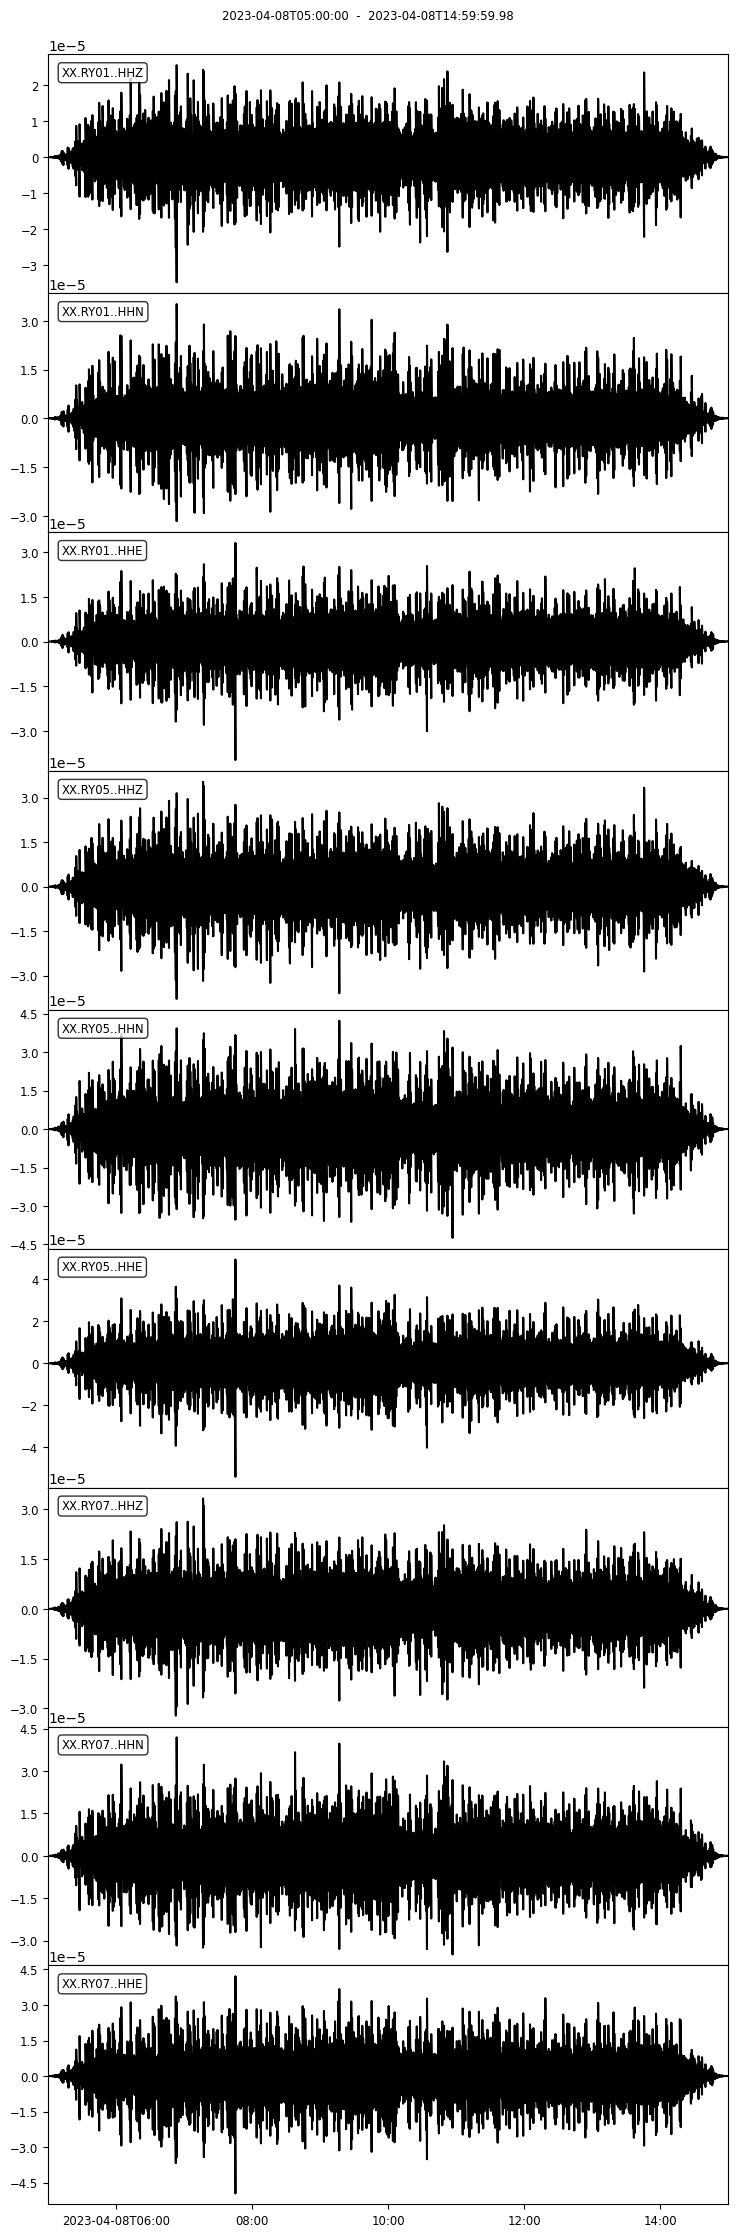

In [7]:
st.plot(equal_scale=False);

## Prepare 2D-Array for Analysis

2D array required for methods (columns=sensors, rows=data)

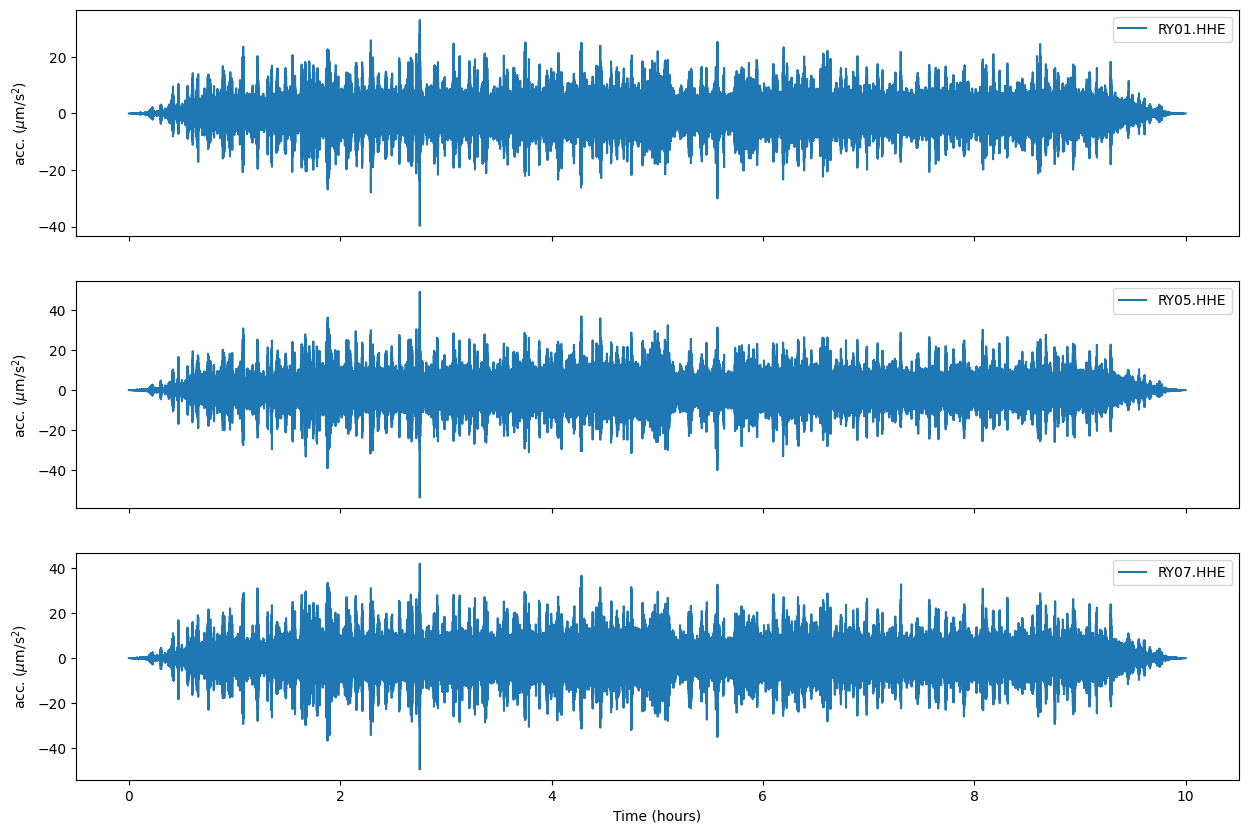

In [8]:
cha = "E"

data, names = [], []

st = st.sort();

for tr in st:
    if cha in tr.stats.channel:
        data.append(tr.data)
        names.append(tr.stats.station)

times = st[0].times()/3600
data = np.array(data).transpose()

colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:green"]


fig, ax = plt.subplots(len(names), 1, figsize=(15,10), sharex=True)

for i, name in enumerate(names):
    # ax[i].plot(times, data[:,i]*1e6, label=name, color=colors[i])
    ax[i].plot(times, data[:,i]*1e6, label=name+".HH"+cha)
    ax[i].legend(loc=1)
    ax[i].set_ylabel(r"acc. ($\mu$m/s$^2$)")

ax[len(names)-1].set_xlabel("Time (hours)")

plt.show();

fig.savefig(config['path_to_figs']+f"ModAna_noise_{config['str_tbeg']}_{config['str_tend']}_traces.png", format="png", dpi=200, bbox_inches='tight');

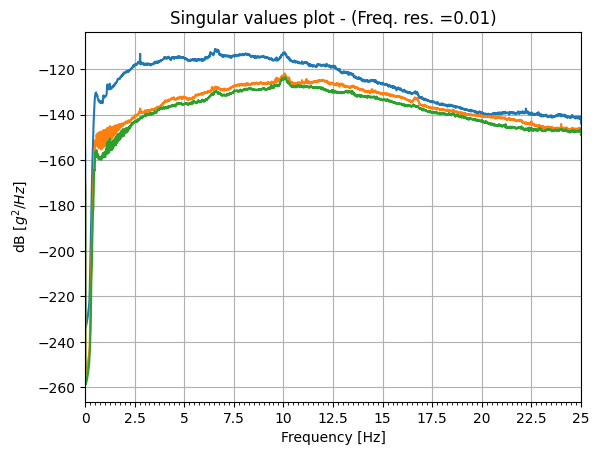

In [9]:
# Run FDD
FDD = oma.FDDsvp(data,  fs, df=0.01, pov=0.5)

ff = np.arange(0, FDD[1]['Data']['Samp. Freq.']/2+FDD[1]['Data']['Freq. Resol.'], FDD[1]['Data']['Freq. Resol.'])

sv = {}
for i, name in enumerate(names):
    sv[name] = FDD[1]['Singular Values'][i][i].real

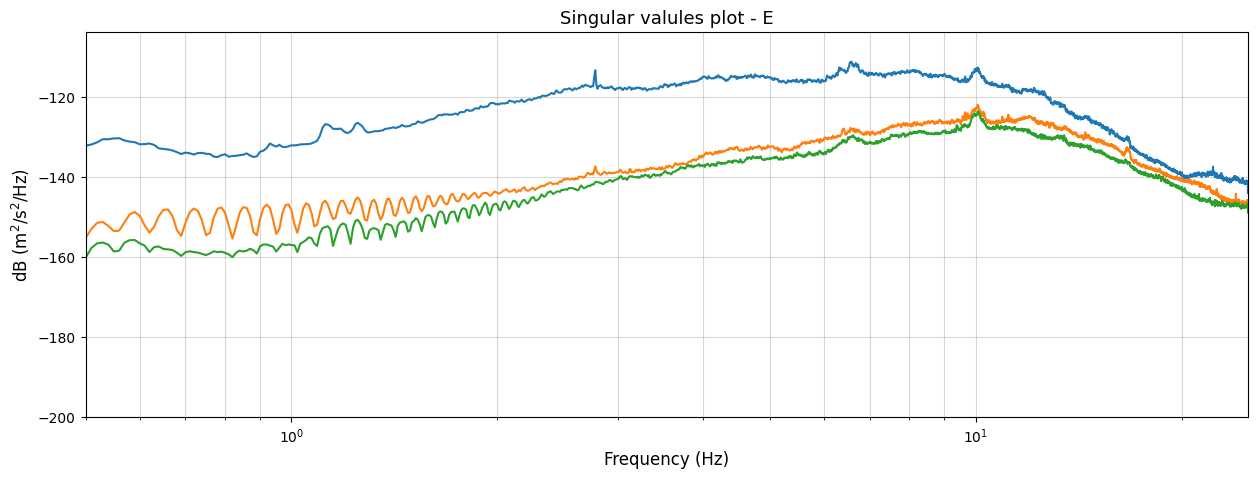

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

font = 12

for key in sv.keys():
    ax.plot(ff,10*np.log10(sv[key]), label=key)

# ax.legend(loc=1, ncols=4)
ax.grid(which="both", alpha=0.5)
ax.set_xscale("log")

ax.set_xlim(config['fmin'], config['fmax']/2)
ax.set_ylim(bottom=-200)

ax.set_xlabel("Frequency (Hz)", fontsize=font)
ax.set_ylabel(r"dB (m$^2$/s$^2$/Hz)", fontsize=font)
ax.set_title(f"Singular valules plot - {cha}", fontsize=font+1)

plt.show();

fig.savefig(config['path_to_figs']+f"ModAna_noise_{config['str_tbeg']}_{config['str_tend']}_svd.png", format="png", dpi=200, bbox_inches='tight');

In [11]:
# ff = np.arange(0, FDD[1]['Data']['Samp. Freq.']/2+FDD[1]['Data']['Freq. Resol.'], FDD[1]['Data']['Freq. Resol.'])

# sv = {}
# dat0 = data[:,0].transpose()
# for i, name in enumerate(names):
#     dat1 = data[:,i:i+1].transpose()
#     dat = np.vstack((dat0, dat1))
#     FDD = oma.FDDsvp(dat.transpose(),  fs, df=0.01, pov=0.5)
#     sv[name] = FDD[1]['Singular Values'][1][1].real

# fig, ax = plt.subplots(1, 1, figsize=(15,5))

# font = 14

# for key in sv.keys():
#     ax.plot(ff,10*np.log10(sv[key]), label=key)

# ax.legend(loc=1, ncols=4)
# ax.grid(which="both", alpha=0.5)
# ax.set_xscale("log")

# ax.set_xlim(config['fmin'], config['fmax']/2)
# ax.set_ylim(bottom=-200)

# ax.set_xlabel("Frequency (Hz)")
# ax.set_ylabel(r"dB (m$^2$/s$^2$/Hz)")
# ax.set_title("Singular valules plot")

# plt.show();

# Frequency Domain Methods

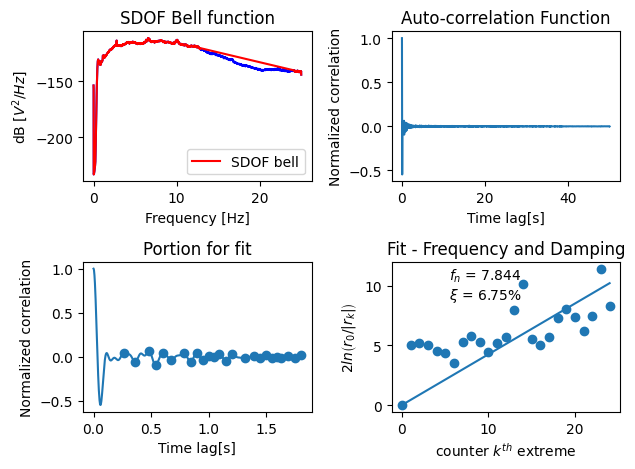

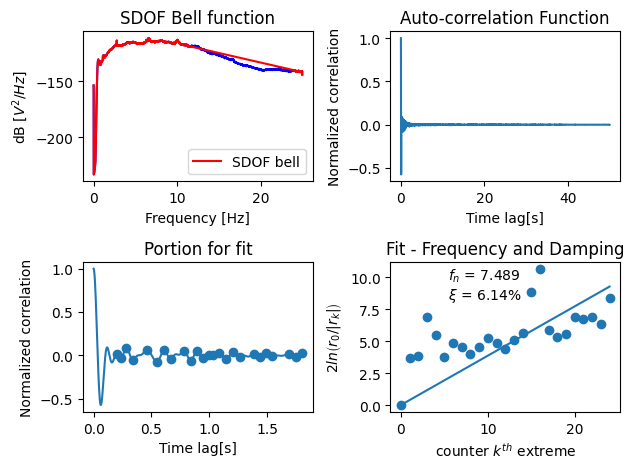

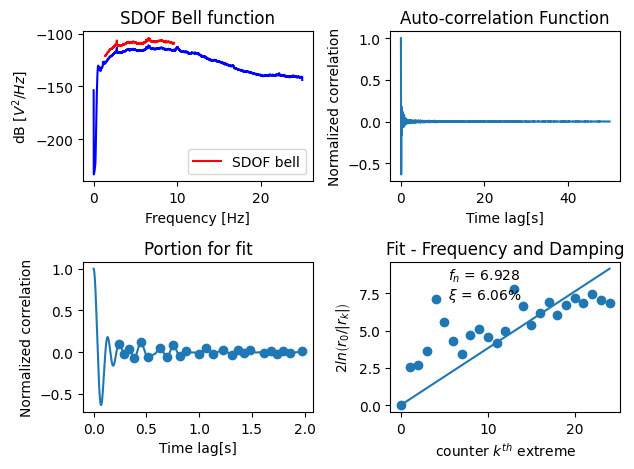

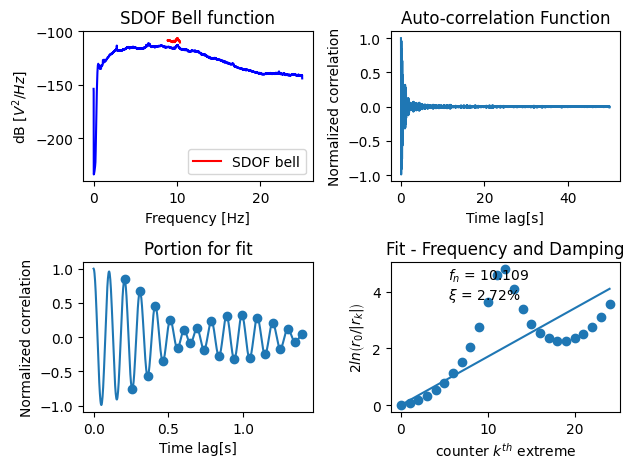

In [12]:
# Define list/array with the peaks identified from the plot
# FreQ = [0.89, 2.6, 4.1, 5.27, 6] # identified peaks
FreQ = [6.8, 10] # identified peaks

# Extract the modal properties
Res_FDD = oma.FDDmodEX(FreQ, FDD[1])
Res_EFDD = oma.EFDDmodEX(FreQ, FDD[1], method='EFDD', npmax=25, plot=True)
Res_FSDD = oma.EFDDmodEX(FreQ, FDD[1], method='FSDD', npmax=25, MAClim=0.95, plot=True)

In [13]:
print(f"RES_FDD: f = {Res_FDD['Frequencies']}")

print(f"RES_EFDD: f = {list(Res_EFDD['Frequencies'])}  d = {list(Res_EFDD['Damping'])}")

print(f"RES_FSDD: f = {list(Res_FSDD['Frequencies'])}  d = {list(Res_FSDD['Damping'])}")



RES_FDD: f = [6.81 9.98]
RES_EFDD: f = [array([7.84354224]), array([7.48895726])]  d = [array([0.06749031]), array([0.06141728])]
RES_FSDD: f = [array([6.92781889]), array([10.10858583])]  d = [array([0.06064123]), array([0.02719013])]


# Time Domain Methods

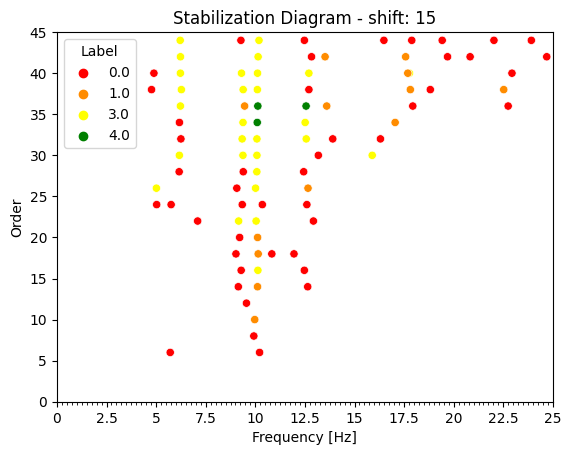

ValueError: could not broadcast input array from shape (45,45) into shape (46,46)

In [14]:
# Run SSI
br = 15
SSIcov= oma.SSIcovStaDiag(data, fs, br)
SSIdat = oma.SSIdatStaDiag(data, fs, br, ordmax=60, lim=(0.01, 0.05, 0.02, 0.1))

# Extract the modal properties
Res_SSIcov = oma.SSIModEX(FreQ, SSIcov[1])
Res_SSIdat= oma.SSIModEX(FreQ, SSIdat[1])

In [ ]:
# =============================================================================
# Make some plots
# =============================================================================
MS_FDD = Res_FDD['Mode Shapes'].real
MS_EFDD = Res_EFDD['Mode Shapes'].real
MS_FSDD = Res_FSDD['Mode Shapes'].real
MS_SSIcov = Res_SSIcov['Mode Shapes'].real
MS_SSIdat = Res_SSIdat['Mode Shapes'].real
_nch = data.shape[1]

MAC = np.reshape(
        [oma.MaC(FI_ex[:,l], MS_FSDD[:,k]).real for k in range(_nch) for l in range(_nch)], # (_nch*_nch) list of MAC values
        (_nch, _nch)) # new (real) shape (_nch x _nch) of the MAC matrix

crossMAC = np.reshape(
        [oma.MaC(MS_SSIcov[:,l], MS_SSIdat[:,k]).real for k in range(_nch) for l in range(_nch)], # (_nch*_nch) list of MAC values
        (_nch,_nch)) # new (real) shape (_nch x _nch) of the MAC matrix

col = ["mode I", "mode II"]
# col = ["mode I", "mode II", "mode III", "mode IV", "mode V"]

MAC = pd.DataFrame(MAC, columns=col, index=col)
crossMAC = pd.DataFrame(crossMAC, columns=col, index=col)

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(MAC,cmap="jet",ax=ax,annot=True, fmt='.3f',)
fig.tight_layout()
plt.show()

fig, ax1 = plt.subplots()
sns.heatmap(crossMAC,cmap="jet", ax=ax1, annot=True, fmt='.3f',)
fig.tight_layout()
plt.show()